# ResNet

In [50]:
pip install opencv-python-headless numpy matplotlib tqdm scikit-image


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [51]:
pip install torch torchvision


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [52]:
pip install seaborn scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [53]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random

from skimage.feature import hog
from skimage import data, exposure

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image


import torch.nn as nn
from scipy.spatial.distance import euclidean

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [54]:
data_root_path = "data/UCF-101"

# On a gardé au préalable uniquement les classes nous intéressant
CLASS_NAMES = sorted(os.listdir(data_root_path))
if '.DS_Store' in CLASS_NAMES :
    CLASS_NAMES.remove('.DS_Store')
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [55]:
## Function to extract frames from a video file
def extract_all_frames_from_video(video_path, frame_rate=3):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return frames

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

## Function to split the video into reference and test sets
def create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75):
    reference_set = {}
    test_set = {}
    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        random.shuffle(video_files)
        split_index = int(len(video_files) * reference_ratio)
        reference_set[class_name] = [os.path.join(class_path, f) for f in video_files[:split_index]]
        test_set[class_name] = [os.path.join(class_path, f) for f in video_files[split_index:]]
    return reference_set, test_set

## Function to extract the frames from all videos in list of set video paths
def extract_frames_from_video_set(video_path_set, frame_rate=3):
    dataset_frames = {}
    for class_name, video_paths in tqdm(video_path_set.items(), desc="Processing classes"):
        dataset_frames[class_name] = []
        for video_path in tqdm(video_paths, desc=f"Processing videos in {class_name}", leave=False):
            frames = extract_all_frames_from_video(video_path, frame_rate)
            dataset_frames[class_name].extend(frames)
    return dataset_frames



In [56]:
reference_path_set, test_path_set = create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75)
reference_frame_dataset = extract_frames_from_video_set(reference_path_set, frame_rate=1)
test_frame_dataset = extract_frames_from_video_set(test_path_set, frame_rate=1)

Processing classes: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


## ResNet Computation

In [57]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, )
model.fc = nn.Identity()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)
model.eval()
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

mps


## Nearest Centroid

In [61]:
def compute_resnet_centroids(train_set, model, preprocess):
    centroids = {}
    
    with torch.no_grad():
        for class_name, frames in tqdm(train_set.items(), desc="Calculating Centroids"):
            features_list = []
            ## batch processing
            batch_size = 32
            batch = []
            for i, frame in enumerate(frames):
                # Preprocess the frame
                pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                input_tensor = preprocess(pil_image).unsqueeze(0).to(device)
                batch.append(input_tensor)

                # If batch is full or it's the last frame, process it
                if len(batch) == batch_size or i == len(frames) - 1:
                    # Process all frames in the batch
                    batch_tensor = torch.cat(batch, dim=0)
                    feature_vectors = model(batch_tensor).cpu().numpy()
                    features_list.extend(feature_vectors)
                    batch = []  # Reset batch for next iteration
                    
            # Calcul du centroïde pour cette classe
            centroids[class_name] = np.mean(features_list, axis=0)
            
    return centroids

# On calcule les signatures moyennes
class_centroids = compute_resnet_centroids(reference_frame_dataset, model, preprocess)

Calculating Centroids: 100%|██████████| 5/5 [00:52<00:00, 10.41s/it]


In [64]:
def predict_nearest_centroid(test_set, centroids, model, preprocess):
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for class_name, frames in tqdm(test_set.items(), desc="Predicting"):
            for frame in frames:
                from PIL import Image
                if isinstance(frame, np.ndarray):
                    img = Image.fromarray(frame)
                
                input_tensor = preprocess(img).unsqueeze(0).to(device)
                test_feature = model(input_tensor).cpu().numpy().flatten()
                
                # Trouver la classe la plus proche
                best_class = None
                min_dist = float('inf')
                
                for c_name, centroid_vec in centroids.items():
                    # Distance euclidienne entre le test et le centroïde
                    dist = euclidean(test_feature, centroid_vec)
                    if dist < min_dist:
                        min_dist = dist
                        best_class = c_name
                
                y_true.append(class_name)
                y_pred.append(best_class)
                
    return y_true, y_pred

# Lancement de l'inférence
y_true, y_pred = predict_nearest_centroid(test_frame_dataset, class_centroids, model, preprocess)

Predicting: 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


--- Global Performance ---
Accuracy:  0.9452
Precision: 0.9510
Recall:    0.9452
F1-Score:  0.9463



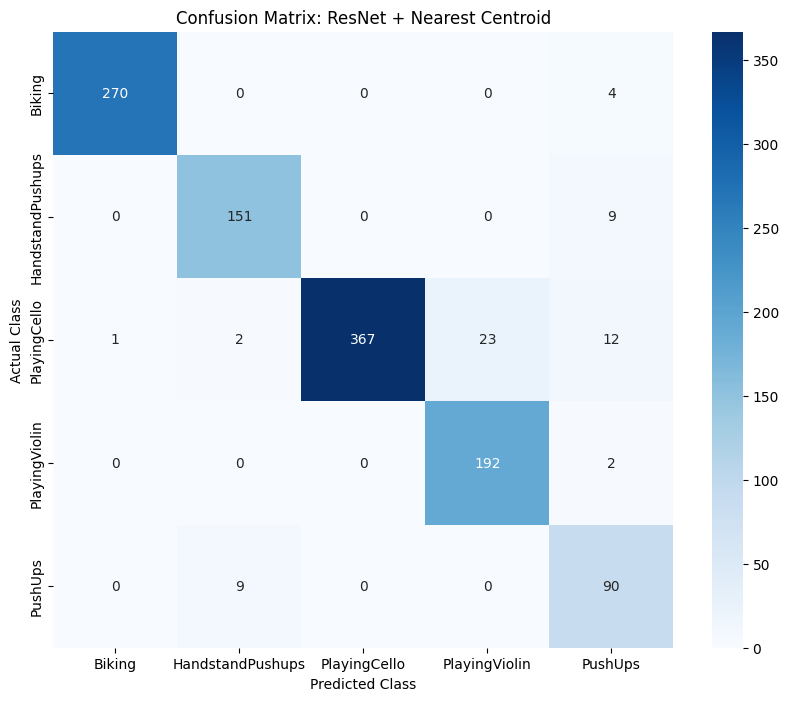

In [65]:
def display_metrics(y_true, y_pred, class_names):
    # 1. Calculate Metrics
    accuracy = accuracy_score(y_true, y_pred)
    # Using 'weighted' average to account for potential class imbalance
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"--- Global Performance ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}\n")

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix: ResNet + Nearest Centroid')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

# Run the evaluation
display_metrics(y_true, y_pred, CLASS_NAMES)

## KNN